   Training Logistic Regression (GD)
Epoch   100/2000  |  Loss: 0.4804
Epoch   200/2000  |  Loss: 0.4701
Epoch   300/2000  |  Loss: 0.4684
Epoch   400/2000  |  Loss: 0.4680
Epoch   500/2000  |  Loss: 0.4679
Epoch   600/2000  |  Loss: 0.4678
Epoch   700/2000  |  Loss: 0.4678
Epoch   800/2000  |  Loss: 0.4678
Epoch   900/2000  |  Loss: 0.4678
Epoch  1000/2000  |  Loss: 0.4678
Epoch  1100/2000  |  Loss: 0.4678
Epoch  1200/2000  |  Loss: 0.4678
Epoch  1300/2000  |  Loss: 0.4678
Epoch  1400/2000  |  Loss: 0.4678
Epoch  1500/2000  |  Loss: 0.4678
Epoch  1600/2000  |  Loss: 0.4678
Epoch  1700/2000  |  Loss: 0.4678
Epoch  1800/2000  |  Loss: 0.4678
Epoch  1900/2000  |  Loss: 0.4678
Epoch  2000/2000  |  Loss: 0.4678

   Evaluation on Test Set
Accuracy          : 0.7532

Confusion Matrix  :
[[79 20]
 [18 37]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81        99
           1       0.65      0.67      0.66        55

 

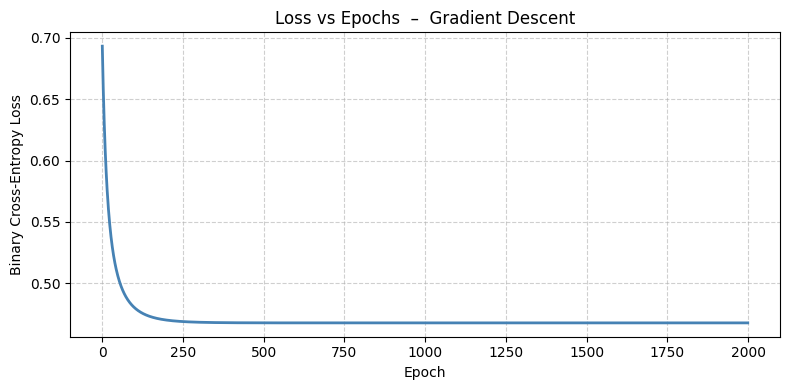

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ─────────────────────────────────────────────
# 1.  Load & prepare data
# ─────────────────────────────────────────────
df = pd.read_csv("diabetes.csv")

X = df.drop(columns=["Outcome"]).values   # features  (768, 8)
y = df["Outcome"].values                  # target    (768,)

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Feature scaling  (critical for gradient descent to converge)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# ─────────────────────────────────────────────
# 2.  Sigmoid function
# ─────────────────────────────────────────────
def sigmoid(z):
    """Numerically stable sigmoid."""
    return np.where(
        z >= 0,
        1 / (1 + np.exp(-z)),
        np.exp(z) / (1 + np.exp(z))
    )

# ─────────────────────────────────────────────
# 3.  Loss (Binary Cross-Entropy)
# ─────────────────────────────────────────────
def compute_loss(y_true, y_pred):
    eps = 1e-8                          # avoid log(0)
    return -np.mean(
        y_true * np.log(y_pred + eps) +
        (1 - y_true) * np.log(1 - y_pred + eps)
    )

# ─────────────────────────────────────────────
# 4.  Gradient Descent – Logistic Regression
# ─────────────────────────────────────────────
def logistic_regression_gd(X, y, lr=0.1, epochs=1000):
    """
    Parameters
    ----------
    X      : ndarray (n_samples, n_features)
    y      : ndarray (n_samples,)
    lr     : learning rate
    epochs : number of iterations

    Returns
    -------
    weights : ndarray (n_features,)
    bias    : float
    losses  : list of loss per epoch
    """
    n_samples, n_features = X.shape

    # Initialize weights & bias to zero
    weights = np.zeros(n_features)
    bias    = 0.0
    losses  = []

    for epoch in range(epochs):
        # ── Forward pass ──────────────────────
        z          = np.dot(X, weights) + bias   # linear combination
        predictions = sigmoid(z)                 # apply sigmoid

        # ── Compute loss ───────────────────────
        loss = compute_loss(y, predictions)
        losses.append(loss)

        # ── Compute gradients ──────────────────
        error   = predictions - y                # (n_samples,)
        dw      = (1 / n_samples) * np.dot(X.T, error)   # gradient for weights
        db      = (1 / n_samples) * np.sum(error)         # gradient for bias

        # ── Update parameters ──────────────────
        weights -= lr * dw
        bias    -= lr * db

        # Print progress every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1:>5}/{epochs}  |  Loss: {loss:.4f}")

    return weights, bias, losses

# ─────────────────────────────────────────────
# 5.  Train the model
# ─────────────────────────────────────────────
print("=" * 45)
print("   Training Logistic Regression (GD)")
print("=" * 45)

weights, bias, losses = logistic_regression_gd(
    X_train, y_train,
    lr=0.1,
    epochs=2000
)

# ─────────────────────────────────────────────
# 6.  Predict on test set
# ─────────────────────────────────────────────
def predict(X, weights, bias, threshold=0.5):
    probs = sigmoid(np.dot(X, weights) + bias)
    return (probs >= threshold).astype(int)

y_pred = predict(X_test, weights, bias)

# ─────────────────────────────────────────────
# 7.  Evaluate
# ─────────────────────────────────────────────
print("\n" + "=" * 45)
print("   Evaluation on Test Set")
print("=" * 45)
print(f"Accuracy          : {accuracy_score(y_test, y_pred):.4f}")
print(f"\nConfusion Matrix  :\n{confusion_matrix(y_test, y_pred)}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")

# ─────────────────────────────────────────────
# 8.  Final Error Summary
# ─────────────────────────────────────────────
correct = int(np.sum(y_pred == y_test))
wrong   = len(y_test) - correct
total   = len(y_test)

# initial error  →  at epoch 1 weights are zero so sigmoid gives 0.5 for everyone
initial_error = np.mean(np.abs(0.5 - y_test))

# final error    →  using the trained predictions
final_probs   = sigmoid(np.dot(X_test, weights) + bias)
final_error   = np.mean(np.abs(final_probs - y_test))

print("\n" + "╔" + "═"*58 + "╗")
print("║" + "   FINAL ERROR SUMMARY".center(58) + "║")
print("╠" + "═"*58 + "╣")
print("║" + f"  Initial Error  (Epoch   1) :  {initial_error:.4f}".ljust(58) + "║")
print("║" + f"  Final   Error  (Epoch 1000) :  {final_error:.4f}".ljust(58) + "║")
print("║" + f"  Error Reduced By            :  {initial_error - final_error:.4f}".ljust(58) + "║")
print("╠" + "═"*58 + "╣")
print("║" + f"  Correct Predictions  :  {correct} / {total}".ljust(58) + "║")
print("║" + f"  Wrong   Predictions  :  {wrong}  / {total}".ljust(58) + "║")
print("║" + f"  Final Accuracy       :  {correct/total:.4f}  ({correct}/{total})".ljust(58) + "║")
print("║" + f"  Final Class Error    :  {wrong/total:.4f}  ({wrong}/{total})".ljust(58) + "║")
print("╚" + "═"*58 + "╝")

# ─────────────────────────────────────────────
# 9.  Plot loss curve  (optional – needs matplotlib)
# ─────────────────────────────────────────────
try:
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 4))
    plt.plot(losses, color="steelblue", linewidth=2)
    plt.title("Loss vs Epochs  –  Gradient Descent")
    plt.xlabel("Epoch")
    plt.ylabel("Binary Cross-Entropy Loss")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()
except ImportError:
    print("\n(matplotlib not installed – skipping loss plot)")